# Time Lag Analysis

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
import sys
import os
import yaml
import pathlib
import glob

import numpy as np
import matplotlib.pyplot as plt
import dask
import dask.array as da
import distributed
from dask_jobqueue import PBSCluster
import astropy.units as u
import astropy.time
import sunpy.map
import ndcube
from astropy.visualization import ImageNormalize,SqrtStretch

import aiacube
from aiacube.prep import register_and_derotate

sys.path.append('../../scripts/')
sys.path.append('../')
from drms_on_ames import Client
from colormaps import *

%matplotlib inline

## Querying Data

In [2]:
c = Client(ssh=True)

In [3]:
keys, q = c.query(
    'aia.lev1[2010-09-29T13:00:00/12h]',
    seg=['image_lev1'],
    key=['WAVELNTH']
)

In [4]:
q

image_lev1
0      /nobackup/drms/SUM5/D179026763/S00000/image_le...
1      /nobackup/drms/SUM6/D179026767/S00000/image_le...
2      /nobackup/drms/SUM3/D179026770/S00000/image_le...
3      /nobackup/drms/SUM6/D179026772/S00000/image_le...
4      /nobackup/drms/SUM6/D179026776/S00000/image_le...
...                                                  ...
28795  /nobackup/drms/SUM1/D179175133/S00000/image_le...
28796  /nobackup/drms/SUM1/D179175137/S00000/image_le...
28797  /nobackup/drms/SUM4/D179175142/S00000/image_le...
28798  /nobackup/drms/SUM6/D179175145/S00000/image_le...
28799  /nobackup/drms/SUM2/D179175148/S00000/image_le...

[28800 rows x 1 columns]

In [5]:
files = (q[(keys['WAVELNTH'] == 94) | (keys['WAVELNTH'] == 171)]
         .values
         .squeeze()
         .tolist())

## Cluster Setup

In [2]:
with open('../../jobqueue-merope.yml','r') as f:
    config = yaml.load(f)['jobqueue']['pbs']

/home4/wtbarnes/miniconda3/envs/aia-on-pleiades/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [3]:
cluster = PBSCluster(**config)
#cluster = distributed.LocalCluster()

In [4]:
client = distributed.Client(cluster)

In [50]:
cluster.scale(5)

## Creating Level 2 Data Cubes

Convert all the 94 and 171 maps to level 1.5 maps and derotate them to a common coordinate frame to create level 2 data cubes for 12 hours of observations.

In [10]:
maps = client.map(sunpy.map.Map, files, pure=True)

In [12]:
headers = client.map(lambda x: x.meta, maps, pure=True)

In [13]:
headers = client.gather(headers)

In [14]:
maps_94 = [m for (m,h) in zip(maps,headers) if h['wavelnth']==94]

In [15]:
maps_171 = [m for (m,h) in zip(maps,headers) if h['wavelnth']==171]

In [16]:
maps_94_lvl_2 = register_and_derotate(maps_94)

In [17]:
maps_171_lvl_2 = register_and_derotate(maps_171)

Next, stack all of the maps into to create our level 2 data cubes for each channel

In [18]:
cube_94 = aiacube.AIACube.from_futures(maps_94_lvl_2)

Changed DATE-OBS from '2010-09-29 13:00:02.120' to '2010-09-29T13:00:02.120''. [astropy.wcs.wcs]


In [19]:
cube_94

NDCube
---------------------
WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'TIME'  
CRVAL : 0.0  0.0  0.0  
CRPIX : 2048.5  2048.5  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  7.6487978747183e-20  0.0  
PC2_1 PC2_2 PC2_3  : -3.2465264823367e-20  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 0.00016666666666667  0.00016666666666667  11.99999999999228  
NAXIS : 4096  4096  3600
---------------------
Length of NDCube: [3600. 4096. 4096.] pix
Axis Types of NDCube: ('time', 'custom:pos.helioprojective.lat', 'custom:pos.helioprojective.lon')

In [20]:
cube_94.data

dask.array<stack, shape=(3600, 4096, 4096), dtype=float64, chunksize=(1, 4096, 4096), chunktype=numpy.ndarray>

In [22]:
cube_171 = aiacube.AIACube.from_futures(maps_171_lvl_2)

Changed DATE-OBS from '2010-09-29 13:00:00.340' to '2010-09-29T13:00:00.340''. [astropy.wcs.wcs]


In [23]:
cube_171

NDCube
---------------------
WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'TIME'  
CRVAL : 0.0  0.0  0.0  
CRPIX : 2048.5  2048.5  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  -2.826753807495e-19  0.0  
PC2_1 PC2_2 PC2_3  : -6.5834946252396e-20  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 0.00016666666666667  0.00016666666666667  11.99999999999228  
NAXIS : 4096  4096  3600
---------------------
Length of NDCube: [3600. 4096. 4096.] pix
Axis Types of NDCube: ('time', 'custom:pos.helioprojective.lat', 'custom:pos.helioprojective.lon')

In [24]:
cube_171.data

dask.array<stack, shape=(3600, 4096, 4096), dtype=float64, chunksize=(1, 4096, 4096), chunktype=numpy.ndarray>

We are only computing the timelags for a single active region so we'll crop our full-disk images.

In [25]:
subcube_94 = cube_94.crop_by_coords(
    lower_corner=(0*u.s, 0*u.arcsec, 50*u.arcsec),
    upper_corner=(12*u.h+12*u.s, 450*u.arcsec, 500*u.arcsec)
)

In [26]:
subcube_171 = cube_171.crop_by_coords(
    lower_corner=(0*u.s, 0*u.arcsec, 50*u.arcsec),
    upper_corner=(12*u.h+12*u.s, 450*u.arcsec, 500*u.arcsec)
)

If we inspect the resulting data cube, we can confirm that we've cropped it a smaller region.

In [27]:
subcube_94

NDCube
---------------------
WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'TIME'  
CRVAL : 0.0  0.0  0.0  
CRPIX : -81.5  1.5  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  7.6487978747183e-20  0.0  
PC2_1 PC2_2 PC2_3  : -3.2465264823367e-20  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 0.00016666666666667  0.00016666666666667  11.99999999999228  
NAXIS : 752  752  3600
---------------------
Length of NDCube: [3600.  752.  752.] pix
Axis Types of NDCube: ('time', 'custom:pos.helioprojective.lat', 'custom:pos.helioprojective.lon')

In [28]:
subcube_94.data

dask.array<getitem, shape=(3600, 752, 752), dtype=float64, chunksize=(1, 752, 752), chunktype=numpy.ndarray>

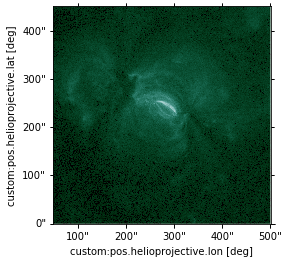

In [29]:
subcube_94[0,:,:].plot(
    cmap='sdoaia94',
    norm=ImageNormalize(vmin=0,vmax=1e2,stretch=SqrtStretch())
)

## Saving and Restoring Data Cubes

As we want to perform our analysis on these cutout level 2 data cubes for our two channels, we do not want to go through this whole prep procedure again. We can save this higher level data product as a `zarr` dataset.

In [30]:
subcube_94.to_zarr('/nobackup/wtbarnes/time_lag/noaa_11109/aia_level_2')

In [31]:
subcube_171.to_zarr('/nobackup/wtbarnes/time_lag/noaa_11109/aia_level_2')

We can then read these datasets back in later without having to go through the rather expensive and time consuming computations above.

In [4]:
subcube_94 = aiacube.AIACube.from_zarr('/nobackup/wtbarnes/time_lag/noaa_11109/aia_level_2', 94*u.angstrom)

In [5]:
subcube_171 = aiacube.AIACube.from_zarr('/nobackup/wtbarnes/time_lag/noaa_11109/aia_level_2', 171*u.angstrom)

## Time Lag

Now, we want to use our level 2 data cubes to calculate the time lag between the 94 and 171 channels in AR NOAA 11109

First, we need to rechunk the data such that we have a single chunk along the time axis.

In [6]:
subcube_94_rechunk = subcube_94.rechunk(subcube_94.data.shape[:1] + (50, 50))

In [7]:
subcube_171_rechunk = subcube_171.rechunk(subcube_171.data.shape[:1] + (50, 50))

Next,  we can use the `time_lag_map` and `peak_correlation_map` functions to compute the time lag and maximum cross-correlation in each pixel over the entire 12-hour window.

In [8]:
tl_map = aiacube.time_lag_map(
    subcube_94_rechunk,
    subcube_171_rechunk,
    timelag_bounds=(-3*u.h, 3*u.h),
)

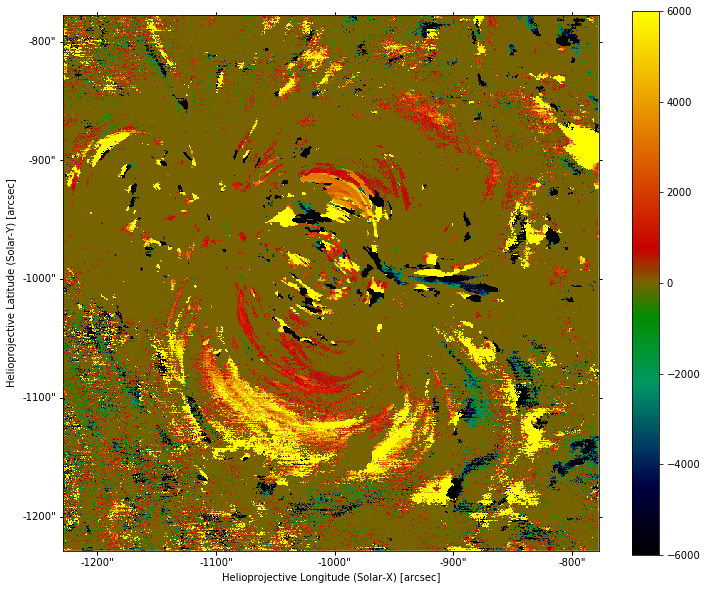

In [9]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection=tl_map)
im = tl_map.plot(
    axes=ax,
    vmin=-(6e3*u.s).to(u.s).value,
    vmax=(6e3*u.s).to(u.s).value,
    cmap='idl_bgry_004',
    title=False
)
ax.grid(alpha=0)
fig.colorbar(im)

In [10]:
maxcc_map = aiacube.peak_cross_correlation_map(
    subcube_94_rechunk,
    subcube_171_rechunk,
    timelag_bounds=(-3*u.h, 3*u.h),
)

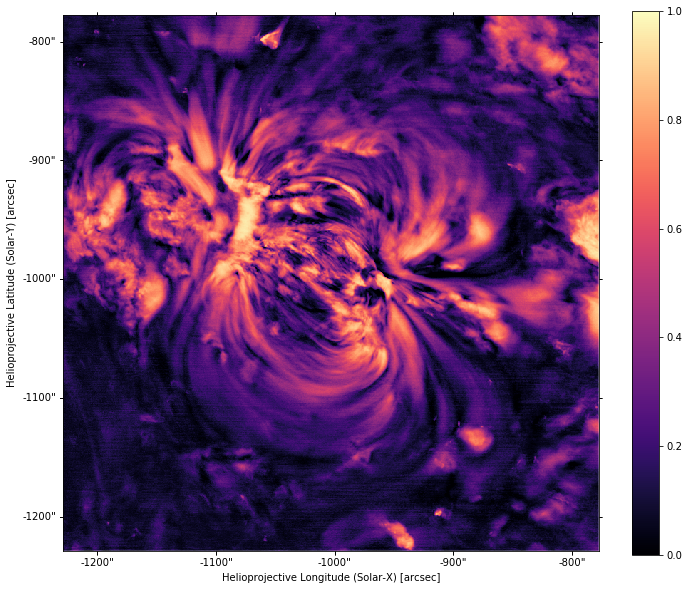

In [11]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection=maxcc_map)
im = maxcc_map.plot(
    axes=ax,
    vmin=0,
    vmax=1,
    cmap='magma',
    title=False
)
ax.grid(alpha=0)
fig.colorbar(im)